### HuggingFace | BERT | PyTorch
- [Code Source](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f' Computations will utilize: {device}')
print('#####  Inital Program Setup is Complete  #####')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
 Computations will utilize: cpu
#####  Inital Program Setup is Complete  #####


In [4]:
# Import data
df = pd.read_csv(r'C:\Data Sciences\Data\all_data_files\reviews.csv')
print(f' Dataframe Shape: {df.shape}')
df.info()
df.head()

 Dataframe Shape: (17016, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17016 entries, 0 to 17015
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17016 non-null  object
 1   userName              17016 non-null  object
 2   userImage             17016 non-null  object
 3   content               17016 non-null  object
 4   score                 17016 non-null  int64 
 5   thumbsUpCount         17016 non-null  int64 
 6   reviewCreatedVersion  14270 non-null  object
 7   at                    17016 non-null  object
 8   replyContent          9046 non-null   object
 9   repliedAt             9046 non-null   object
 10  sortOrder             17016 non-null  object
 11  appId                 17016 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.6+ MB


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Through Genesis,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,40,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo
1,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,38,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo
2,gp:AOqpTOHgR1qnD3AZbHvKJ6-BbO4pMkokJS2JT1UvdVI...,Glenn Anderson,https://play-lh.googleusercontent.com/a/AATXAJ...,EDITED. So the app works as expected. It does ...,1,12,5.15.3.0,2022-01-22 00:29:36,For any questions feel free to contact us at w...,2022-01-11 15:51:10,most_relevant,com.anydo
3,gp:AOqpTOE3fQQpkWOMbSHW-DwukAnILBbMwBHEcbReiit...,Sydney Stoll,https://play-lh.googleusercontent.com/a/AATXAJ...,I have had this app for almost a year. I was r...,1,79,5.15.2.1,2021-11-07 15:58:27,This could happen if a user pressed on an adve...,2021-11-08 14:36:27,most_relevant,com.anydo
4,gp:AOqpTOH_GtAiezLqm0tHyquE1arU2C_L__IFTeqJxsg...,Bob Garcia,https://play-lh.googleusercontent.com/a-/AOh14...,I liked this app until recently. I discovered ...,1,78,5.15.3.0,2021-12-06 00:55:00,Sorry you feel this way Bob. As explained by o...,2021-12-06 12:36:53,most_relevant,com.anydo


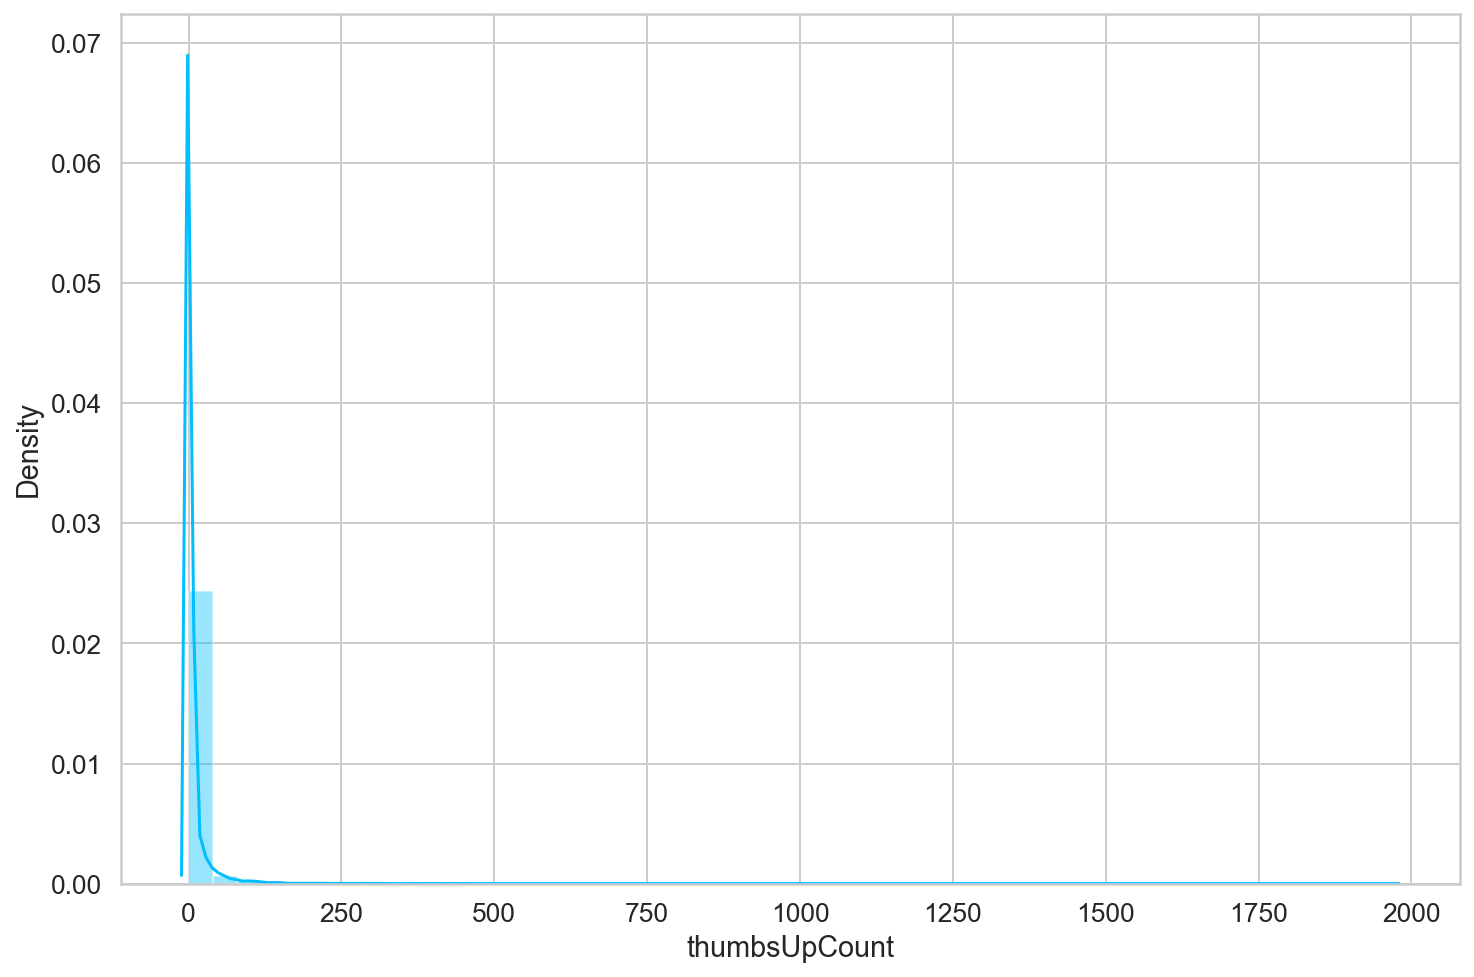

In [5]:
sns.distplot(df['thumbsUpCount'])
plt.savefig('Thumbs Distribution by Counts.png')

In [6]:
def thumbs_up(thumbs):
    thumbs = int(thumbs)

    if thumbs <= 1:
        return '0-1'

    elif thumbs >=2 and thumbs <=3:
        return '2-3'

    elif thumbs >=4 and thumbs <=5:
        return '4-5'

    elif thumbs >=6 and thumbs <=7:
        return '6-7'

    else:
        return 'Over-8'

df['thumbs_up_grouping'] = df.thumbsUpCount.apply(thumbs_up)

<AxesSubplot:xlabel='thumbs_up_grouping', ylabel='count'>

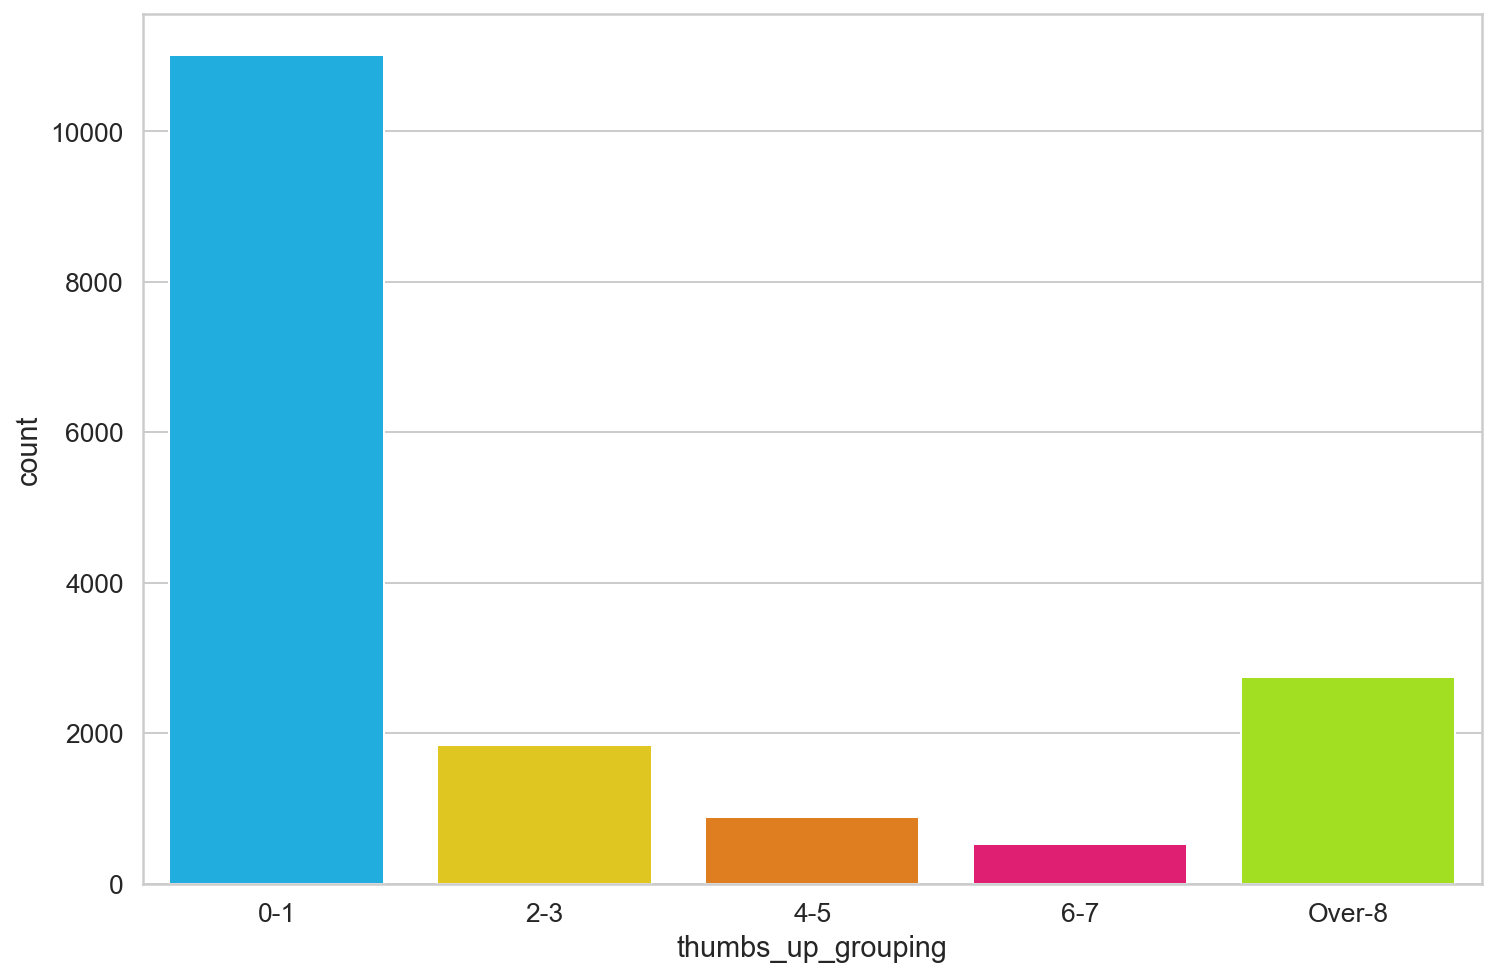

In [7]:
order = ['0-1','2-3','4-5','6-7','Over-8']
sns.countplot(df['thumbs_up_grouping'], order=order)

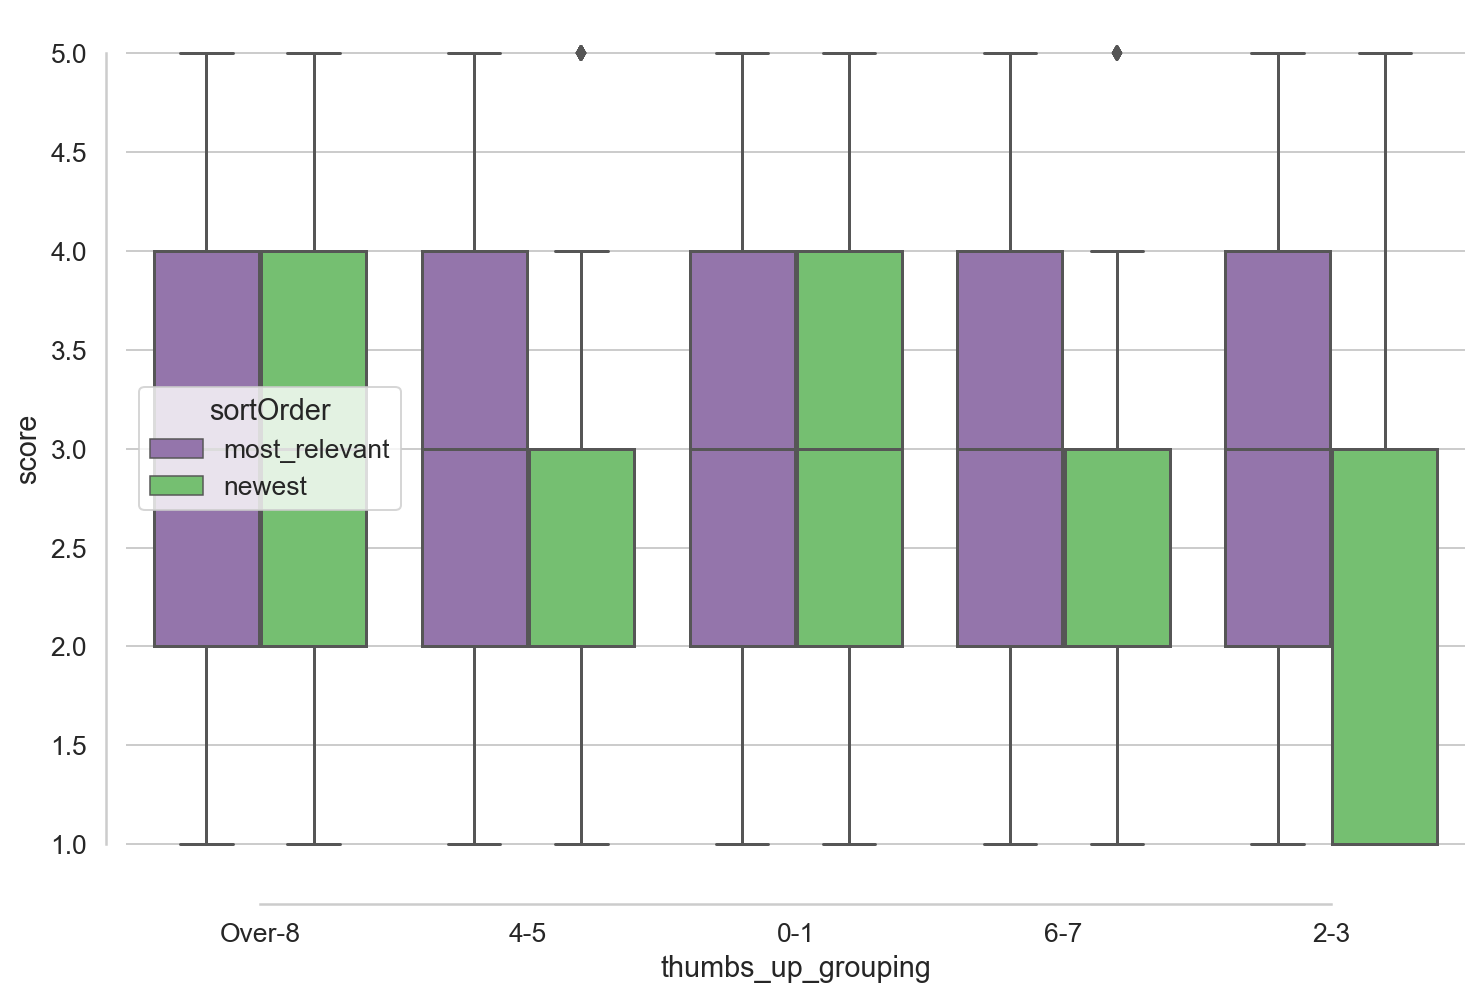

In [8]:
sns.boxplot(x="thumbs_up_grouping", y="score", hue = "sortOrder", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

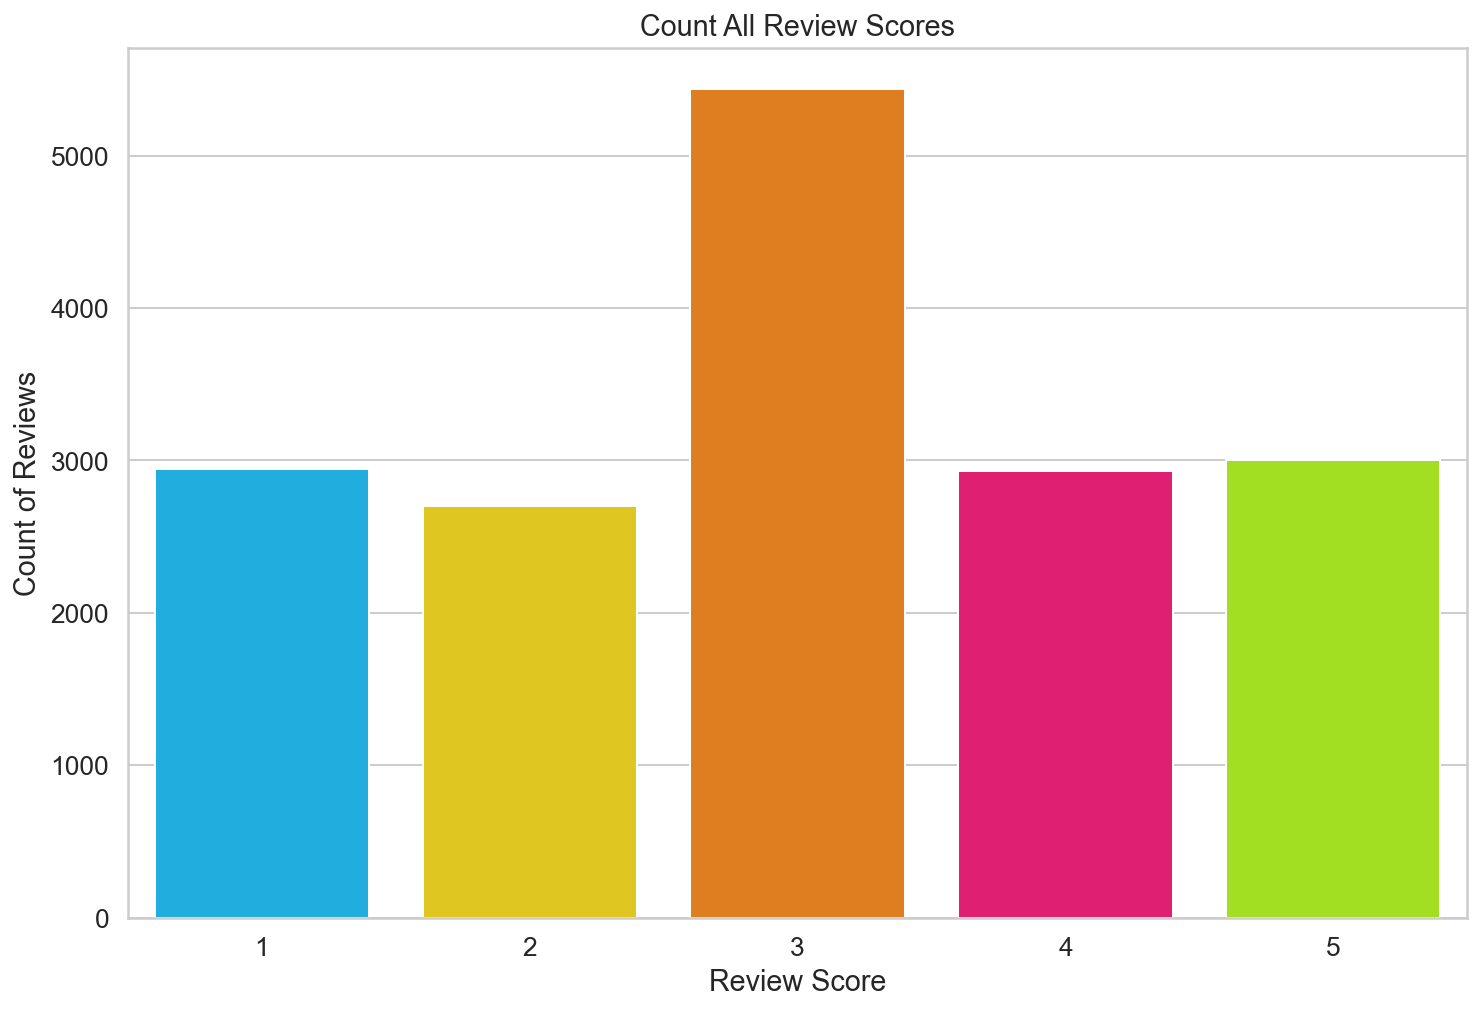

In [9]:
# Review distribution of review score:
sns.countplot(df.score)
plt.title('Count All Review Scores')
plt.ylabel('Count of Reviews')
plt.xlabel('Review Score')
plt.savefig('Pre-Processed Review Scores.png')

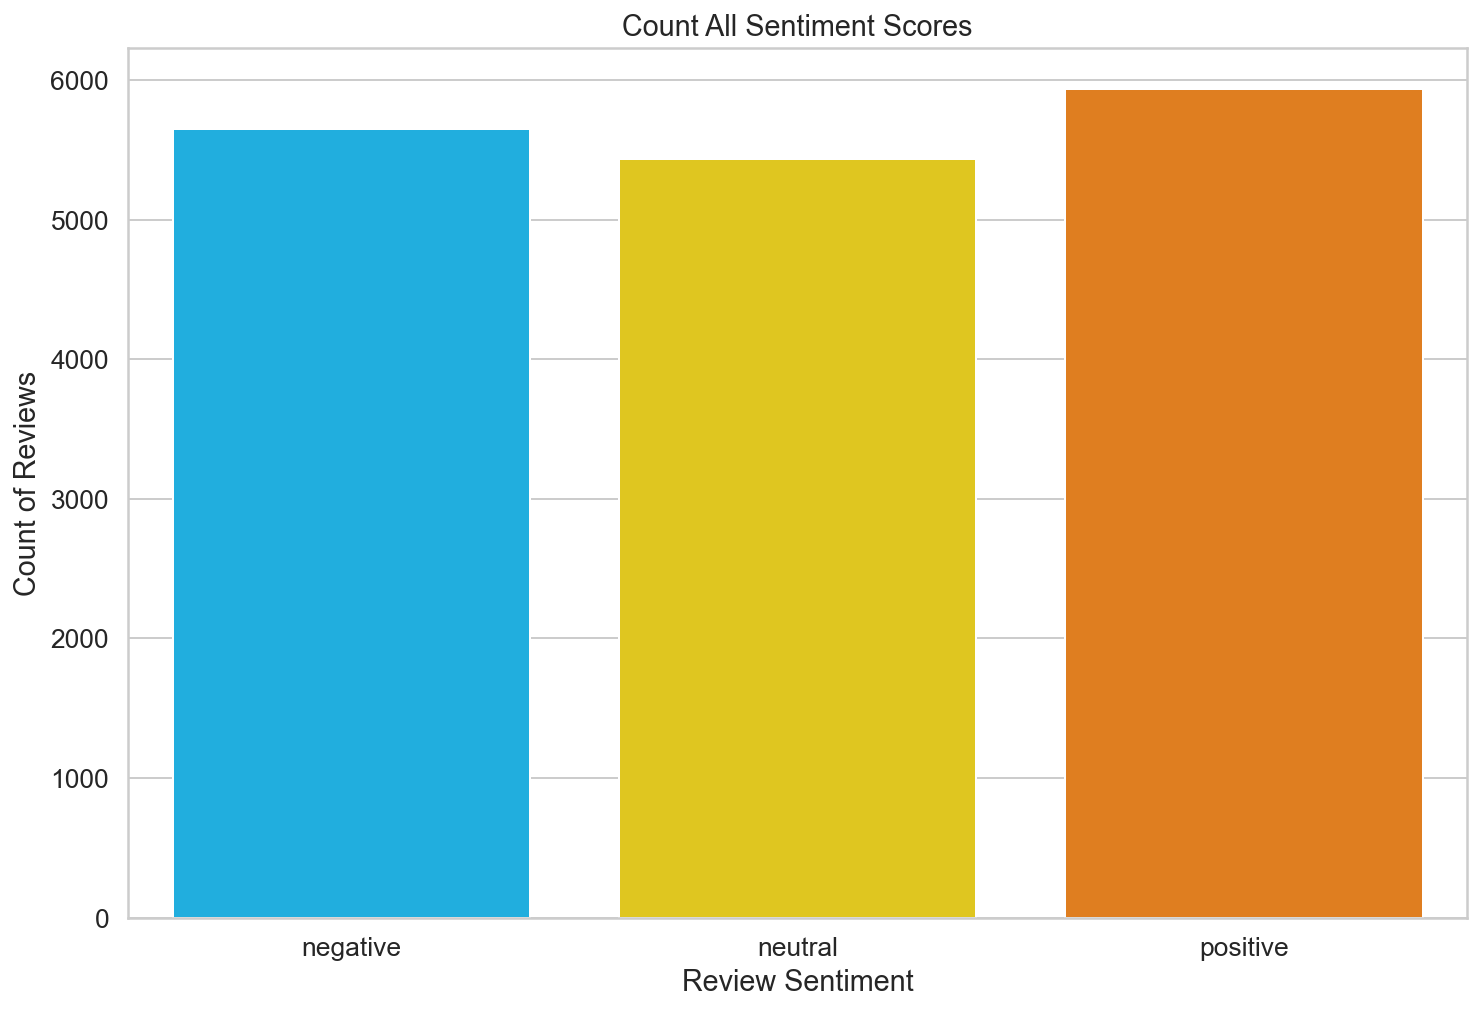

In [10]:
# Re-assign review scores into 0 (negative), 1 (neutral), and 2 (positive):
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.title('Count All Sentiment Scores')
plt.ylabel('Count of Reviews')
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names)
plt.savefig('Post-Processed Sentiment Scores.png')

In [12]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,thumbs_up_grouping,sentiment
0,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Through Genesis,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,40,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo,Over-8,0
1,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,38,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo,Over-8,0
2,gp:AOqpTOHgR1qnD3AZbHvKJ6-BbO4pMkokJS2JT1UvdVI...,Glenn Anderson,https://play-lh.googleusercontent.com/a/AATXAJ...,EDITED. So the app works as expected. It does ...,1,12,5.15.3.0,2022-01-22 00:29:36,For any questions feel free to contact us at w...,2022-01-11 15:51:10,most_relevant,com.anydo,Over-8,0
3,gp:AOqpTOE3fQQpkWOMbSHW-DwukAnILBbMwBHEcbReiit...,Sydney Stoll,https://play-lh.googleusercontent.com/a/AATXAJ...,I have had this app for almost a year. I was r...,1,79,5.15.2.1,2021-11-07 15:58:27,This could happen if a user pressed on an adve...,2021-11-08 14:36:27,most_relevant,com.anydo,Over-8,0
4,gp:AOqpTOH_GtAiezLqm0tHyquE1arU2C_L__IFTeqJxsg...,Bob Garcia,https://play-lh.googleusercontent.com/a-/AOh14...,I liked this app until recently. I discovered ...,1,78,5.15.3.0,2021-12-06 00:55:00,Sorry you feel this way Bob. As explained by o...,2021-12-06 12:36:53,most_relevant,com.anydo,Over-8,0


In [13]:
# Constaint Variables:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [15]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [16]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [17]:
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,thumbs_up_grouping,sentiment
0,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Through Genesis,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,40,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo,Over-8,0
1,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,38,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo,Over-8,0
2,gp:AOqpTOHgR1qnD3AZbHvKJ6-BbO4pMkokJS2JT1UvdVI...,Glenn Anderson,https://play-lh.googleusercontent.com/a/AATXAJ...,EDITED. So the app works as expected. It does ...,1,12,5.15.3.0,2022-01-22 00:29:36,For any questions feel free to contact us at w...,2022-01-11 15:51:10,most_relevant,com.anydo,Over-8,0


Text(0.5, 0, 'Token count')

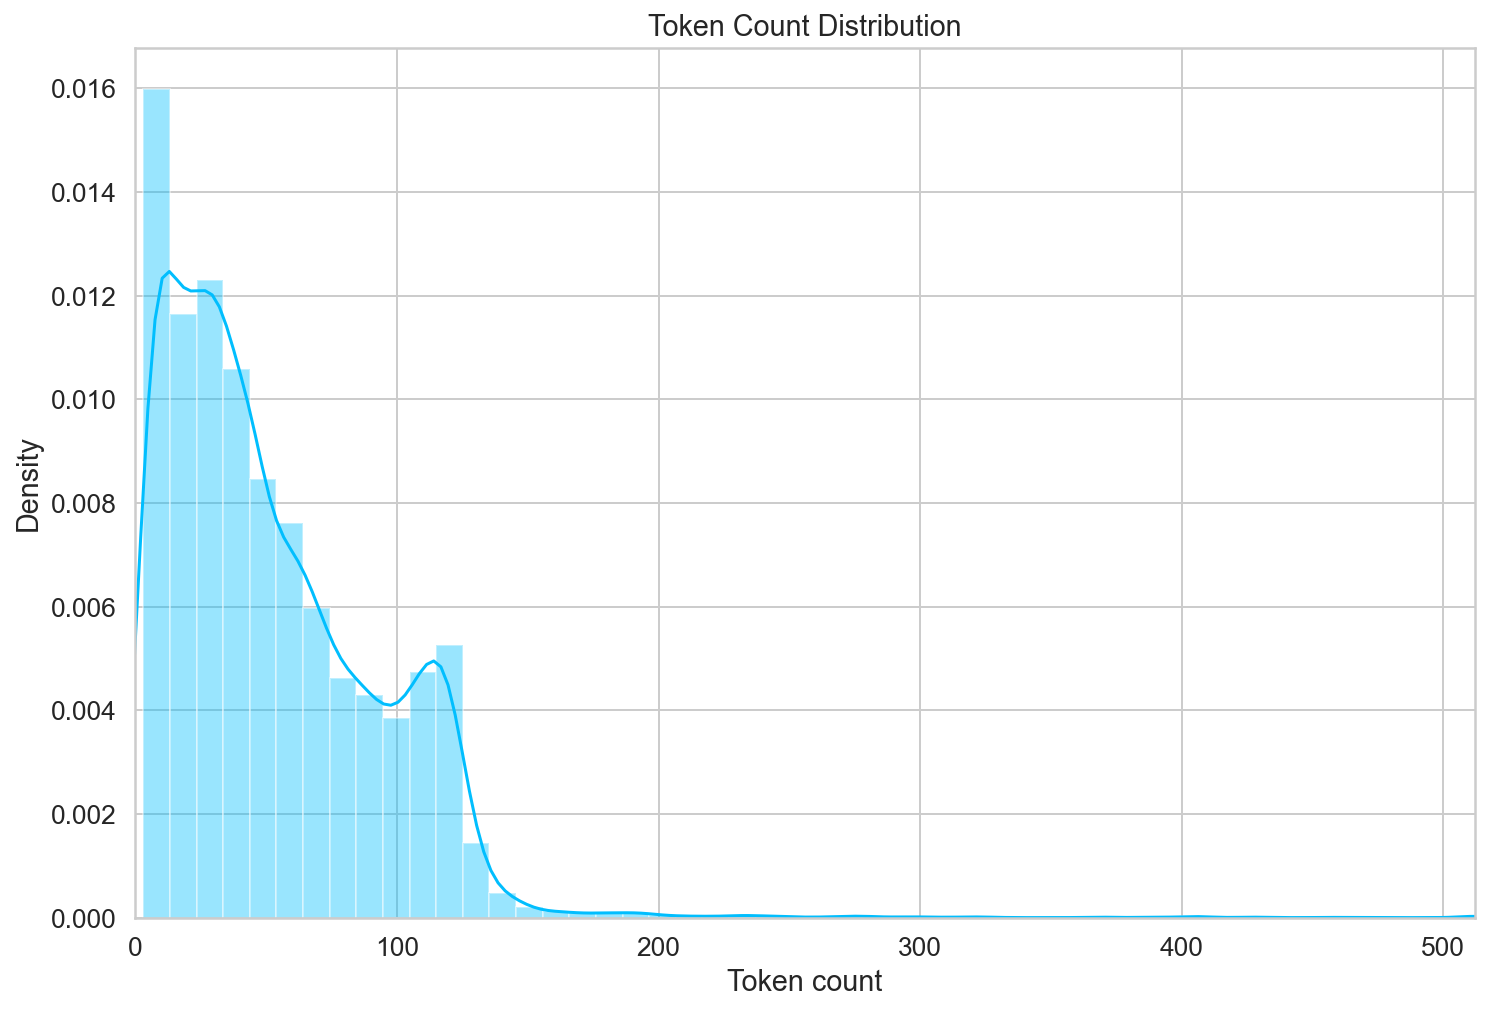

In [18]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.title('Token Count Distribution')
plt.xlim([0, 512]);
plt.xlabel('Token count')

In [ ]:
class GPReviewDataset(Dataset):

  ''' This class will create a pytorch dataset'''

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Based on distribution from above, it appears 160 MAX_LEN will work for this problem:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state=RANDOM_SEED)

print('### Shape Describtion ###')
print(f'      Train Shape: {df_train.shape}')
print(f'       Test Shape: {df_test.shape}')
print(f' Validation Shape: {df_val.shape}')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'], 
    attention_mask = encoding['attention_mask']
)